# Deep Learning - Tutorial Facial Keypoints Detection
### Magister en Data Science

#### Instituto Data Science, Universidad del Desarrollo

By Hernan Rivera 

* Tutorial esta basado en el tutorial de Daniel Nouri fundador de Natural Vision. 
* Original: http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial

Tutorial Contents

* Requisitos previos
* Los datos
* Primer modelo: una sola capa oculta.
* Probándolo
* Segundo modelo: convolutions.
* Aumento de datos
* Cambio de la tasa de aprendizaje y el impulso con el tiempo
* Abandonar
* Especialistas en formación.
* Pre-entrenamiento supervisado.
* Conclusión

### 1. Requisitos previos

* Se debe instalar las librerias Theano y lasagne

In [1]:
#!pip install -r https://raw.githubusercontent.com/dnouri/kfkd-tutorial/master/requirements.txt
# En mi caso previamente instalada, por lo tanto, se comenta el comando.

### 2. Los datos

* Cremoa funcion para chequear los datos dispoibles para el desafio

In [2]:
import os
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


* Los datos se descargan desde el sitio web de kagle (https://www.kaggle.com/c/facial-keypoints-detection/data)

In [3]:
FTRAIN = './data/training.zip'
FTEST = './data/test.zip'

In [4]:
def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

In [5]:
X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

* Podemos observar las caractetisticas principales del dataset, en donde destaca lo siguiente:
 > 
 * La data de entrenamineto consta de 7049 imagenes de 96 x 96 pixeles en escala de grises.
 * Existen 30 caracteristicas que corresponden a los pares (puntos) X, Y de los 15 puntos claves de la cara.
 * Para algunos puntos claves solo tenemso aprox 2000 etiquetas, mientras que para otros cerca de 7000 etiquetas.
 * **y.shape == (2140, 30)** nos dice que solo hay 2140 imagenes en el dataset con todas las features
 * Las imagenes estan en escala [0,1] en vez de [0, 255]
 * Los valores de X, Y estan entre [-1,1] y las imagenes de [0,95]

### 3. Primer modelo: una sola capa oculta.

* Creamos una red Lasagne con una solo una capa:
 > 
 * Primero inicializamos la red con 3 capas (input, hidden y output). En este punto se especifica el nombre y su orden.
 * Luego se especifica las caracteristicas de cada capa
 * Al establecer output_nonlinearity como None se utilza la funcion de activacion por defecto para capas densas, esto es rectifier, que corresponde a un simple max(0, x).
 
<img src="img/rectifier.png" />
  
  * Los pesos son inicializados por Lasagne utilizado una distribución uniforme utilizando inicialización <a href="http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf">Glorot-style</a>
  * Se utilizará a "nesterov_momentum gradient descendent" como metodo de optimización
  * El Learning rate será de 0.01
  * Se estable como un problema de regresión
  * Se establece el numero de epoch a 400

<img src="img/methods.gif" />

* Comparación de metodos de optimización(by Alec Radford). La estrella denota el minimo global en el plano de errores. Nosotros usaremos Nesterov's Accelerated Gradient Descent (NAG) en este tutorial.

In [6]:
net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=400,  # we want to train this many epochs
    verbose=1, # Print 1, Not print 0
    )

In [7]:
net1.fit(X, y)

# Neural Network with 924730 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input     9216
  1  hidden     100
  2  output      30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.15207     0.04027    3.77636  0.61s
      2     0.02756     0.01754    1.57120  0.28s
      3     0.01487     0.01352    1.09994  0.45s
      4     0.01296     0.01267    1.02263  0.42s
      5     0.01210     0.01192    1.01453  0.37s
      6     0.01137     0.01135    1.00235  0.37s
      7     0.01086     0.01094    0.99273  0.34s
      8     0.01046     0.01060    0.98685  0.39s
      9     0.01013     0.01030    0.98284  0.41s
     10     0.00984     0.01005    0.97961  0.31s
     11     0.00960     0.00982    0.97704  0.26s
     12     0.00938     0.00962    0.97488  0.27s
     13     0.00918     0.00944    0.97300  0.32s
     14     0.00901     0.00928    0.97114  0.28s
     15     0.00885     0.00

    118     0.00455     0.00516    0.88098  0.37s
    119     0.00453     0.00515    0.88040  0.42s
    120     0.00451     0.00513    0.87988  0.36s
    121     0.00450     0.00512    0.87910  0.30s
    122     0.00448     0.00510    0.87842  0.28s
    123     0.00446     0.00508    0.87820  0.30s
    124     0.00445     0.00507    0.87721  0.25s
    125     0.00443     0.00506    0.87650  0.32s
    126     0.00442     0.00504    0.87604  0.26s
    127     0.00440     0.00502    0.87546  0.26s
    128     0.00438     0.00501    0.87462  0.33s
    129     0.00437     0.00500    0.87393  0.30s
    130     0.00435     0.00498    0.87329  0.31s
    131     0.00434     0.00497    0.87266  0.35s
    132     0.00432     0.00495    0.87209  0.33s
    133     0.00430     0.00494    0.87142  0.28s
    134     0.00429     0.00493    0.87090  0.32s
    135     0.00427     0.00491    0.87031  0.27s
    136     0.00426     0.00490    0.86977  0.26s
    137     0.00424     0.00488    0.86912  0.26s


    239     0.00311     0.00385    0.80850  0.36s
    240     0.00310     0.00384    0.80792  0.36s
    241     0.00309     0.00383    0.80699  0.37s
    242     0.00309     0.00383    0.80632  0.32s
    243     0.00308     0.00382    0.80581  0.26s
    244     0.00307     0.00382    0.80526  0.27s
    245     0.00307     0.00381    0.80488  0.29s
    246     0.00306     0.00380    0.80449  0.28s
    247     0.00305     0.00379    0.80397  0.27s
    248     0.00304     0.00379    0.80347  0.28s
    249     0.00303     0.00378    0.80289  0.28s
    250     0.00303     0.00377    0.80235  0.29s
    251     0.00302     0.00377    0.80165  0.26s
    252     0.00301     0.00376    0.80088  0.29s
    253     0.00301     0.00376    0.80034  0.27s
    254     0.00300     0.00375    0.79981  0.26s
    255     0.00299     0.00374    0.79948  0.26s
    256     0.00299     0.00374    0.79911  0.26s
    257     0.00298     0.00373    0.79851  0.26s
    258     0.00297     0.00372    0.79792  0.26s


    382     0.00247     0.00327    0.75555  0.26s
    383     0.00243     0.00334    0.72687  0.26s
    384     0.00252     0.00349    0.72326  0.27s
    385     0.00261     0.00351    0.74322  0.25s
    386     0.00257     0.00338    0.76003  0.25s
    387     0.00245     0.00327    0.75068  0.25s
    388     0.00240     0.00327    0.73401  0.25s
    389     0.00244     0.00334    0.73115  0.25s
    390     0.00248     0.00334    0.74204  0.25s
    391     0.00246     0.00328    0.74840  0.25s
    392     0.00241     0.00324    0.74168  0.25s
    393     0.00239     0.00328    0.72977  0.25s
    394     0.00243     0.00334    0.72609  0.25s
    395     0.00247     0.00337    0.73467  0.26s
    396     0.00246     0.00332    0.74315  0.25s
    397     0.00241     0.00325    0.74131  0.25s
    398     0.00237     0.00324    0.73238  0.26s
    399     0.00239     0.00328    0.72855  0.25s
    400     0.00242     0.00330    0.73423  0.25s


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10a086f98>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10a086f60>,
     check_input=True, custom_scores=None, hidden_num_units=100,
     input_shape=(None, 9216),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=400, more_params={},
     objective=<function objective at 0x10a2721e0>,
     objective_loss_function=<function squared_error at 0x109fa01e0>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog object at 0x10a2b54a8>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo object at 0x10a2b54e0>],
     output_nonlinearity=None, output_num_units=30, regression=True,
     scores_train=[], scores_valid=[],
     train_spl

* En las lineas de ejecución que corresponde a los epoch se puede observar la perdida (MSE) para el set de entrenamiento y el set de validación y el ratio entre ellos (Train / Val). NeuralNet por defecto divide la data para establecer un 20% para evaluacion
* Que tan buenos fueron los resultados? ** Train Loss =  0.00321 **
* Recuerden que dividimos el objetivo (target) por 48, cuando los escalamos para que fuera un intervalo [-1, 1]. Por lo tanto, para calcular el Root-Mean-Squart-Error, debemos miltiplicar por 48. 

In [8]:
print("RMSE:", np.sqrt(0.00321) * 48)

RMSE: 2.7195293710493367


### Chequeando.
El objeto net1 en realidad mantiene un registro de los datos que imprime en la tabla. Podemos acceder a ese registro a través del atributo **train_history_**. Dibujemos esas dos curvas:

In [9]:
import matplotlib.pyplot as pyplot

train_loss = np.array([i["train_loss"] for i in net1.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])
pyplot.plot(train_loss, linewidth=3, label="train")
pyplot.plot(valid_loss, linewidth=3, label="valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(1e-3, 1e-2)
pyplot.yscale("log")
pyplot.show()

* Podemos ver que nuestra red tiene overfitting, pero no está tan mal. En particular, no vemos un punto en el que el error de validación vuelva a empeorar, por lo que no parece que una "early stopping" una técnica que se usa comúnmente para evitar el sobreajuste, sea muy útil en este momento. Tenga en cuenta que no utilizamos ninguna regularización en absoluto, aparte de elegir una pequeña cantidad de neuronas en la capa oculta, una configuración que mantendrá el control excesivo de los ajustes.

* ¿Cómo se ven las predicciones de la red? Vamos a elegir algunos ejemplos del conjunto de pruebas y comprobar:

ImageId    1783
Image      1783
dtype: int64


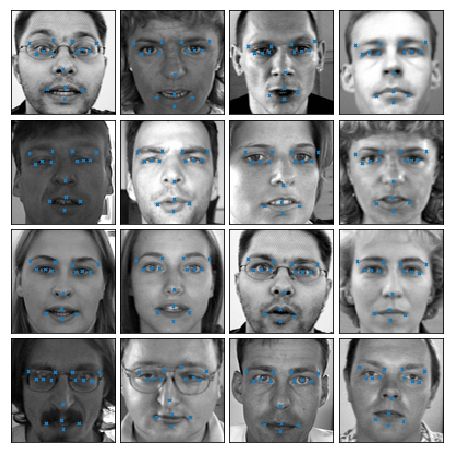

In [10]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

X, _ = load(test=True)
y_pred = net1.predict(X)

fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], y_pred[i], ax)

pyplot.show()

* Las predicciones parecen razonables, pero a veces están bastante lejos. Vamos a tratar de hacerlo un poco mejor.

### 4. Segundo modelo: convolutions